In [1]:
# data file location
data_dir = './Flickr8k_Dataset/'
captions_file = './Flickr8k_text/Flickr8k.token.txt'

In [2]:
# variables
start_word = 'startseq'
end_word = 'endseq'
unknown_word = 'unk'
extracted_features_file = 'features.pkl'
embedding_dim = 256
lstm_units = 512

In [3]:
# list of train and validation images
train_image_id_list = []
val_image_id_list = []

In [4]:
# create list of train images
train_images = './Flickr8k_text/Flickr_8k.trainImages.txt'
with open(train_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        train_image_id_list.append(image.split('.')[0])

In [5]:
# create list of train images
val_images = './Flickr8k_text/Flickr_8k.devImages.txt'  
with open(val_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        val_image_id_list.append(image.split('.')[0])

In [6]:
print(len(train_image_id_list))
print(len(val_image_id_list))

6000
1000


In [7]:
# open file for reading
f = open(captions_file, 'r')

In [8]:
# read file
sentences = f.readlines()

In [9]:
# create a word tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [10]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# create a list of image ids and captions
image_ids = []
captions = {}
for sentence in sentences:
    image_and_caption_index, caption = sentence.split('\t')
    image_id = image_and_caption_index.split('.')[0]
    caption = start_word + ' ' + caption + ' ' + end_word
    caption = text_to_word_sequence(caption)
    caption = ' '.join(caption)
    # append to lists
    if image_id not in image_ids:
        image_ids.append(image_id)
        captions[image_id] = []
    captions[image_id].append(caption)

In [11]:
print(len(image_ids))
print(len(captions))
print(captions[image_ids[3]])

8092
8092
['startseq a man lays on a bench while his dog sits by him endseq', 'startseq a man lays on the bench to which a white dog is also tied endseq', 'startseq a man sleeping on a bench outside with a white and black dog sitting next to him endseq', 'startseq a shirtless man lies on a park bench with his dog endseq', 'startseq man laying on bench holding leash of dog sitting on ground endseq']


In [12]:
# create a list of all captions
all_captions = []
for image_id, caption in captions.items():
    all_captions += caption

In [13]:
len(all_captions)

40460

In [14]:
# fit tokenizer on all captions
tokenizer.fit_on_texts(all_captions)

In [15]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8496

In [16]:
max_len = max(len(text_to_word_sequence(caption)) for caption in all_captions)
max_len

39

In [ ]:
# VGG16 model pretrained on ImageNet to be used as our CNN encoder
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(include_top=True, weights='imagenet')
base_model.summary()

In [ ]:
# create a new model using CGG16 but without the softmax prediction layer
from tensorflow.keras.models import Model

In [ ]:
feature_extractor_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
feature_extractor_model.summary()

In [ ]:
# extract features
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

features = {}

for image_id in image_ids:
    image = data_dir + image_id + '.jpg'
    feature = []
    try:
        image = load_img(image, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, 224, 224, 3))
        image = preprocess_input(image)

        feature = feature_extractor_model.predict(image)
    except FileNotFoundError:
        pass
    features[image_id] = feature

In [ ]:
# store features in a pickle file
from pickle import dump
dump(features, open(extracted_features_file, 'wb'))

In [17]:
# open extracted features file
from pickle import load
f_extracted = load(open(extracted_features_file, 'rb'))

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def load_data(image_id, caption_list):
    X_encoder = []
    X_decoder = []
    y_decoder = []
        
    # load features from file
    image = f_extracted[image_id]
    
    # integer encode the caption
    integer_encoded_caption_list = tokenizer.texts_to_sequences(caption_list)
    
    # train on first caption for testing purposes
    # integer_encoded_caption_list = [integer_encoded_caption_list[0]]
    
    for caption in integer_encoded_caption_list:
        for i in range(1, len(caption)):
            in_seq = caption[:i]
            out_seq = caption[i]
                
            X_encoder.append(image)
            X_decoder.append(in_seq)
            y_decoder.append(out_seq)
        
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

In [19]:
def train_data_generator():
    while True:
        # for image_id, caption_list in captions.items():
        for image_id in train_image_id_list:
            caption_list = []
            try:
                caption_list = captions[image_id]
            except KeyError:
                pass
            if len(caption_list) == 0:
                continue
            if len(f_extracted[image_id]) == 0:
                continue
            X_encoder, X_decoder, y_decoder = load_data(image_id, caption_list)
            X_encoder = X_encoder.reshape((X_encoder.shape[0], 4096))
            X_decoder = pad_sequences(X_decoder, maxlen=max_len)
            y_decoder = to_categorical(y_decoder, num_classes=vocab_size)
            
            yield [[X_encoder, X_decoder], y_decoder]

In [20]:
def val_data_generator():
    while True:
        for image_id in val_image_id_list:
            caption_list = []
            try:
                caption_list = captions[image_id]
            except KeyError:
                pass
            if len(caption_list) == 0:
                continue
            if len(f_extracted[image_id]) == 0:
                continue
            X_encoder, X_decoder, y_decoder = load_data(image_id, caption_list)
            X_encoder = X_encoder.reshape((X_encoder.shape[0], 4096))
            X_decoder = pad_sequences(X_decoder, maxlen=max_len)
            y_decoder = to_categorical(y_decoder, num_classes=vocab_size)
            
            yield [[X_encoder, X_decoder], y_decoder]

In [21]:
# create sequential models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, Activation, Input, add, TimeDistributed, Dropout

In [22]:
# create image encoder model(CNN)
input_image_encoder = Input(shape=(4096,))
fc = Dense(lstm_units, activation='relu')(input_image_encoder)
# output_image_encoder = RepeatVector(max_len)(fc)

# create decoder model(RNN)
input_sequence_decoder = Input(shape=(max_len,))
embedding_sequence_model = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_sequence_decoder)
lstm_sequence_model = LSTM(lstm_units)(embedding_sequence_model)
# td_sequence_model = TimeDistributed(Dense(embedding_dim, activation='relu'))(lstm_sequence_model)

# merge inputs
merged = add([fc, lstm_sequence_model])

# language model (decoder)
# lstm_encoder_decoder = LSTM(lstm_units, return_sequences=False)(merged)
fc_encoder_decoder = Dense(lstm_units, activation='relu')(merged)
dropout_encoder_decoder = Dropout(0.5)(fc_encoder_decoder)
output_encoder_decoder = Dense(vocab_size, activation='softmax')(dropout_encoder_decoder)

# tie it together [image, seq] [word]
model = Model(inputs=[input_image_encoder, input_sequence_decoder], outputs=output_encoder_decoder)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 256)      2174976     input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          2097664     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM

In [23]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# callback for saving model
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="NIC-{epoch:02d}-{loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [25]:
# create generator callback
generator_train = train_data_generator()
generator_val = val_data_generator()

In [26]:
model.fit_generator(generator_train, epochs=5, verbose=1, steps_per_epoch=len(train_image_id_list), validation_data=generator_val, validation_steps=len(val_image_id_list), callbacks=callbacks_list)

Epoch 1/5


/home/amol/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5999/6000 [============================>.] - ETA: 0s - loss: 4.4241 - acc: 0.2790
Epoch 00001: loss improved from inf to 4.43574, saving model to NIC-01-4.4357.h5
6000/6000 [==============================] - 668s 111ms/step - loss: 4.4239 - acc: 0.2790 - val_loss: 3.9268 - val_acc: 0.3154
Epoch 2/5
5999/6000 [============================>.] - ETA: 0s - loss: 3.8796 - acc: 0.3193
Epoch 00002: loss improved from 4.43574 to 3.89144, saving model to NIC-02-3.8914.h5
6000/6000 [==============================] - 641s 107ms/step - loss: 3.8795 - acc: 0.3193 - val_loss: 3.7798 - val_acc: 0.3271
Epoch 3/5
5999/6000 [============================>.] - ETA: 0s - loss: 3.7019 - acc: 0.3300
Epoch 00003: loss improved from 3.89144 to 3.71388, saving model to NIC-03-3.7139.h5
6000/6000 [==============================] - 639s 106ms/step - loss: 3.7017 - acc: 0.3300 - val_loss: 3.7210 - val_acc: 0.3340
Epoch 4/5
5999/6000 [============================>.] - ETA: 0s - loss: 3.6105 - acc: 0.3347
Epoch 0000

In [27]:
# create test image id list
test_image_id_list = []

# create list of test images
test_images = './Flickr8k_text/Flickr_8k.testImages.txt'
with open(test_images, 'r') as f:
    image_list = f.readlines()
    for image in image_list:
        test_image_id_list.append(image.split('.')[0])

In [28]:
len(test_image_id_list)

1000

In [29]:
# extract features of a random test file
test_image_id = test_image_id_list[239]

image_feature = f_extracted[test_image_id]

In [30]:
# create unique integer to word mapping
int_to_word = {int:word for word, int in tokenizer.word_index.items()}

In [31]:
# initialize seed word
seed_word = start_word
seed_word

'startseq'

In [32]:
# get caption list for testing purposes
caption_list = captions[test_image_id]

X_encoder = image_feature

In [33]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image_file = data_dir + test_image_id + '.jpg'
test_image = cv2.imread(image_file)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

startseq a man in a red shirt is standing in a field endseq


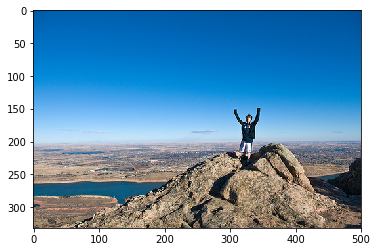

In [34]:
# generate sequence
for i in range(max_len):
    # integer encode seed word
    sequence = tokenizer.texts_to_sequences([seed_word])
    # pad sequence
    sequence = pad_sequences(sequence, maxlen=max_len)
    # create input tensor
    X_test = [X_encoder, sequence]
    # predict next word in sequence
    y_pred = model.predict(X_test, verbose=0)
    # calculate maximum index from one hot encoded tensor
    y_pred = np.argmax(y_pred)
    # convert index back to word
    word = int_to_word[y_pred]
    # break if word cannot be mapped back
    if word is None:
        break
    # append current predicted word to the sequence which will be the input in the next timestep
    seed_word += ' ' + word
    # break if endseq is predicted
    if word == 'endseq':
        break

# print generated sequence
print(seed_word)
plt.imshow(test_image)